In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed()
# tf.set_random_seed()

'''
RNN linear is a net that tries to follow a circle with only linear components
'''

class RNN_linear():
    def __init__(self, prediction_length = 40, batch_size = 1500, learning_rate = 0.01):           
        
        # Network variables
        self.prediction_length = prediction_length
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # Placeholders for training
        self.data_start = tf.placeholder(tf.float32, [None, 2])
        self.data_true = tf.placeholder(tf.float32, [None, self.prediction_length, 2])
            
        ###############
        # Given data_start, rotate in a circle at rate omega
        ###############
        init_state = self.data_start
        
        current_state = init_state
        self.est_data_series = []
        for num_pred in range(self.prediction_length):
            # send state through the identity layer
            layer_1 = tf.layers.dense(
              init_state, 2, tf.identity, use_bias=True)
            # set the next state to be current output
            next_state = layer_1
            # append next state to the est-data-series
            self.est_data_series.append(next_state)
            current_state = next_state

#         self.est_data_series = tf.reshape(self.est_data_series,[batch_size,data_length,2])
        self.est_data_series = tf.transpose(self.est_data_series, [1,0,2])
        
        ###############################################
        # Define surrogate loss and optimization tensor
        ###############################################
        self.surr = tf.losses.mean_squared_error(self.est_data_series, self.data_true)
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.update_op = self.optimizer.minimize(self.surr)

        ###############
        # Start session
        ###############
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
            

    def test_net(self, data_start, data_true):
        """
        Test net function. Evaluates the session
        """

        test_cost, test_est_series, test_mse_loss = self.sess.run([self.surr,self.est_data_series, 
                                                                   self.surr], 
                                                             feed_dict={
                self.data_start: data_start,
                self.data_true: data_true,
                })
        
#         # save the weights from the layers
#         with tf.variable_scope("identity_layer", reuse=True):
#             weights_1 = tf.get_variable("kernel").eval(session = self.sess)
#             bias_1 = tf.get_variable("bias").eval(session = self.sess)
                    
        return (test_cost,test_est_series, test_mse_loss)#, weights_1, bias_1)
    
            
    def train_net(self, data_start, data_true):
        """
        Train net function. Calls self.update_op.
        """

        _ , train_cost = self.sess.run([self.update_op, self.surr], feed_dict={
                self.data_start: data_start,
                self.data_true: data_true,
                })
        
        return train_cost
    


/home/laura/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def data_generation(epochs, omega, data_length, batch_size):
    
    # create training data
    import numpy as np
    import scipy.signal as sig
    from numpy import linalg as LA
    import matplotlib.pyplot as plt

    # Create training and test data for the NN

    # number of random channels that will be trained and tested on
    num_train=epochs*batch_size
    num_test=batch_size

    # QPSK
    data_train = np.zeros((num_train, data_length,2))
    data_test = np.zeros((num_test, data_length,2))
    start_train = np.zeros((num_train, 2))
    start_test = np.zeros((num_test, 2))

    for i in range(num_train):
        # first choose a random starting point on the unit circle
        # there are 2pi radians in a circle, choose random number between 0 and 2pi
        random_start = np.random.rand()*2*np.pi
    #     random_start = 0
        start_train[i,:] = np.array([np.cos(random_start), np.sin(random_start)])
        # real part of data
        data_train[i,0,:]=np.array([np.cos(random_start), np.sin(random_start)])

        # rotate data according to omega
        for j in range(1,data_length):
            data_train[i,j,0]=(data_train[i,j-1,0]*np.cos(omega)-data_train[i,j-1,1]*np.sin(omega))
            data_train[i,j,1]=(data_train[i,j-1,0]*np.sin(omega)+data_train[i,j-1,1]*np.cos(omega))

        if i % 100000 == 0:
            print(i)


    for i in range(num_test):
        # first choose a random starting point on the unit circle
        # there are 2pi radians in a circle, choose random number between 0 and 2pi
        random_start = np.random.rand()*2*np.pi
    #     random_start = 0 
        start_test[i,:]=np.array([np.cos(random_start), np.sin(random_start)])
        # real part of data
        data_test[i,0,:]=np.array([np.cos(random_start), np.sin(random_start)])

        # rotate data according to omega
        for j in range(1,data_length):
            data_test[i,j,0]=(data_test[i,j-1,0]*np.cos(omega)-data_test[i,j-1,1]*np.sin(omega))
            data_test[i,j,1]=(data_test[i,j-1,0]*np.sin(omega)+data_test[i,j-1,1]*np.cos(omega))

    print("Data generation complete.")
    
    return(data_train, data_test, start_train, start_test)

In [8]:
epochs = 2000
omega = 1/50
data_length = 100
batch_size = 100

# generate the data
(data_train, data_test, start_train, start_test) = data_generation(epochs, omega, data_length, batch_size)

0
100000
Data generation complete.


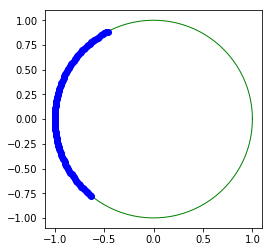

In [9]:
t = np.linspace(0,np.pi*2,100)
plt.plot(np.cos(t), np.sin(t), linewidth=1, color='g')
plt.gca().set_aspect('equal', adjustable='box')

for j in range(0,data_length):
    x = data_test[0,j,0]
    y = data_test[0,j,1]
    plt.plot(x,y,'bo')
    
# plt.plot(x1,y1,'bo')
plt.show()

Net trained on constant omega =  0.02
Epoch 0, Train Cost 1.001015305519104, Test Cost: 0.9702341556549072, MSE Loss: 0.9702341556549072
Epoch 100, Train Cost 0.17955127358436584, Test Cost: 0.17815503478050232, MSE Loss: 0.17815503478050232
Epoch 200, Train Cost 0.028379803523421288, Test Cost: 0.026753565296530724, MSE Loss: 0.026753565296530724
Epoch 300, Train Cost 0.0032280341256409883, Test Cost: 0.0031214419286698103, MSE Loss: 0.0031214419286698103
Epoch 400, Train Cost 0.0002721586497500539, Test Cost: 0.0002596729318611324, MSE Loss: 0.0002596729318611324
Epoch 500, Train Cost 1.5794947103131562e-05, Test Cost: 1.529331893834751e-05, MSE Loss: 1.529331893834751e-05
Epoch 600, Train Cost 6.54186976589699e-07, Test Cost: 6.246367547646514e-07, MSE Loss: 6.246367547646514e-07
Epoch 700, Train Cost 1.711434727269534e-08, Test Cost: 1.6715077322260186e-08, MSE Loss: 1.6715077322260186e-08
Epoch 800, Train Cost 3.11982273348832e-10, Test Cost: 3.073704346601147e-10, MSE Loss: 3.073

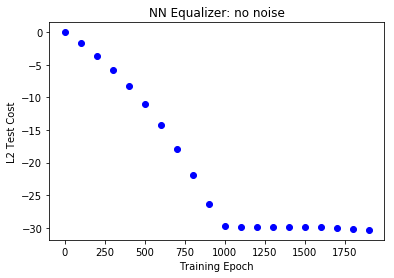

In [10]:
### RNN circle ###

import matplotlib.pyplot as plt   
import numpy as np


print("Net trained on constant omega = ", omega)

mc_losses = []
# define equalizer NN class object
net = RNN_linear(data_length, batch_size, learning_rate = 0.01)

for epoch in range(epochs):
    current_start = epoch*batch_size
    data_train_orig_batch = data_train[current_start:(current_start+batch_size),:,:]
    start_train_orig_batch = start_train[current_start:(current_start+batch_size),:]   

    train_cost = net.train_net(start_train_orig_batch, data_train_orig_batch)

    if epoch % 100 == 0: 


#         (test_cost, test_omega, test_loss_mse, w1, b1) = net.test_net(
#             data_test, start_test)
        (test_cost, test_est_series, test_loss_mse) = net.test_net(
            start_test, data_test)

        mc_losses.append(test_cost)


        plt.plot(epoch, np.log(test_cost), 'bo')
        print('Epoch {}, Train Cost {}, Test Cost: {}, MSE Loss: {}'.format(epoch, train_cost,test_cost, 
                                                                            test_loss_mse))


plt.xlabel('Training Epoch')
plt.ylabel('L2 Test Cost')
plt.title('NN Equalizer: no noise')
# plt.text(1000, .025, r'NN equalizer')
# plt.text(0.5, .025, r'Zero Force equalizer')
plt.show()




In [11]:
# print(np.array(test_est_series).shape)

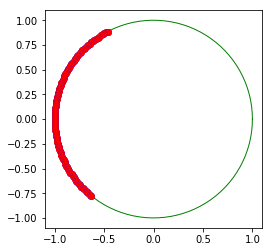

In [12]:
data_est = np.array(test_est_series)

t = np.linspace(0,np.pi*2,100)
plt.plot(np.cos(t), np.sin(t), linewidth=1, color='g')
plt.gca().set_aspect('equal', adjustable='box')

m = 0 # test number

for j in range(0,data_length):
    x1 = data_test[m,j,0]
    y1 = data_test[m,j,1]
    plt.plot(x1,y1,'bo')
    
    x2 = data_est[m,j,0]
    y2 = data_est[m,j,1]
    plt.plot(x2,y2,'ro')
    
#     print(x1-x2, y1-y2)
    
# plt.plot(x1,y1,'bo')
plt.show()